<a href="https://colab.research.google.com/github/yvrjsharma/Keras-edition-deux/blob/main/Keras_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working With Keras: A Deep Dive

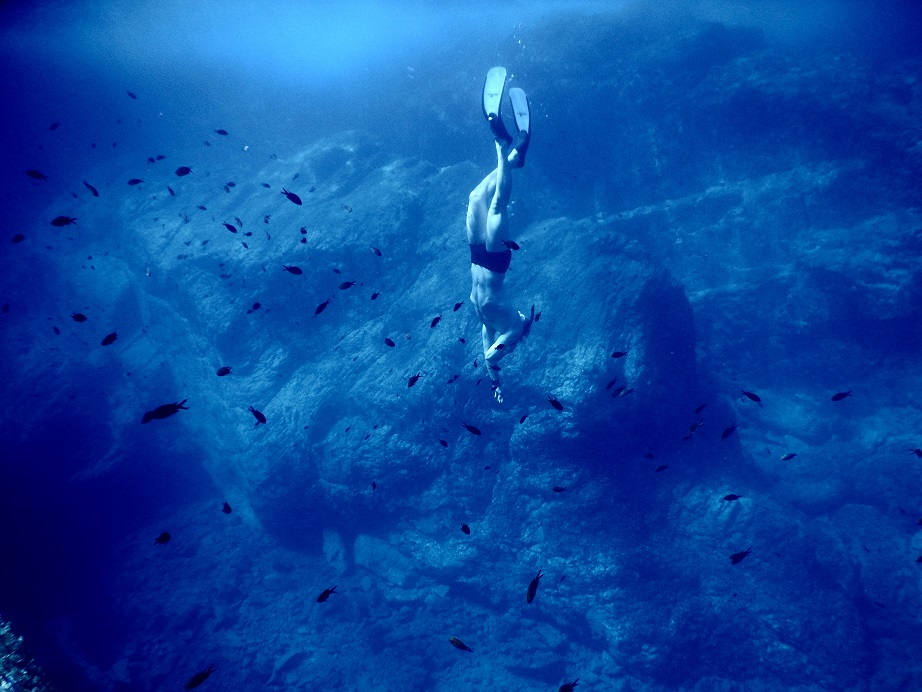

Photo by <a href="https://unsplash.com/@marco_assmann?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Marco Assmann</a> on <a href="https://unsplash.com/s/photos/deep-dive?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

This chapter explains how you can build models using Keras techniques like Sequential class, Functional API and also model subclassing. It also touches upon Keras *Callbacks* and *TensorBoard*. 

What we have used so far in the journey - Sequential model, Dense Layers, model.compile(), model.fit() for traininig, model.evaluate() for ebaluating and model.predict() for inference. In this chapter/blogpost you will get to learn everything you need to handle advanced deep learning use cases like computer vision, NLP, generative deep learning *etc.* Lets Go!



## Ways to build Keras models

There are different ways or APIs to build Keras models and different ways to train thse models as well.
* *Sequential model API* - acts like a python list or simple stack of layers, very easy to use.
* *Fucntional API* - Graph like model architectures, easy as well as flexible to use.
* *Model subclassing* - you write everything from scratch, gives you more control, hoever more chances to make errors. 

### Sequential model

Layer weights are created only when the input shape is known to a model. This happens when you call a model's build() function with input shape. 

In [1]:
#Building basic sequential model
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(64,"relu"),
                          layers.Dense(10, "softmax")])

#another way
model = keras.Sequential(name="example_model")
model.add(layers.Dense(64, activation="relu", name="first_layer"))
model.add(layers.Dense(10, activation="softmax", name="second_layer"))

#Error - ValueError: Weights for model sequential_5 have not yet been created.
#uncomment and run
#model.weights

Lets build the model by telling it the shape of its inputs. Note that you can't *summarize* a model using summary() funtcion until it is being build first. Summary() is acctually a very good model in debugging your model workflow when there are layers that modify input shapes in complex ways. -

In [ ]:
#not telling the no. of samples right now, thus None
#telling the dimension of each sample, which is 3 i this eg.
model.build(input_shape=(None,3))
#This will run this time
model.weights

#Notice weights shape as (3,64) in the output bias would be (64,)
#next layer is softmax (10), thus weights shape is (64,10) and bias would be (10,)

In [4]:
#Summary of a netwrok comes handy in debugging
#Notice first layer output is shaped (None,64), it would have been (60000,64) in case of MNIST eg. in previous post/chapters
#Similarly you can understand the output shape for second or softmax layer- (None,10)
model.summary()

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (Dense)         (None, 64)                256       
                                                                 
 second_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


You can't call summary() function over a model untless you build it and declare input shape while doing so. However there is another way, in this we build Sequential model on the fly by declaring the input shape in advance as shown in below code piece -



In [5]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, "relu"))

#runs without error 
#using summary to check the shape on the fly
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [6]:
#adding more layers on the fly and checking how shape of model changes
model.add(layers.Dense(10, "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### Functional API

* Sequential API can only be used to express models which have single input and single output, and which can be expressed using linear fashion oflayers in a list format.
* Most of the Keras model in the wild use Functional API. They have multiple inputs as well as outputs and a nonlinear topology.

Lets implement the above model in Functional API way -

In [7]:
#Start by declaring Input
inputs = keras.Input(shape=(3,), name="input")
#inpputs is a symbolic tensor - one with no data but has rest of specifications
print(inputs.shape, inputs.dtype)

#next we create a layer and call it on inputs
#all keras layers can be called on real data tensors as well as symbolic tensors
#result will be an another symbolic tensor
features = layers.Dense(64, "relu")(inputs)
print(features.shape)

#getting outputs
outputs = layers.Dense(10, "softmax")(features)

#instantiating the model by using Model constructor with inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

#displaying final summary
model.summary()

(None, 3) <dtype: 'float32'>
(None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


* To implement model with multiple inputs and outputs, you need to declare all different inputs (as symbolic tensors) first, then you declare a layer that combines (or concat) all input tensos into a single one, and then similarly declare multiple outputs. Lastly you have to instantiate Model class  with all inputs and outputs as lists.

* Lets look at below example to understand this better --

In [8]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

* To train this type of a model, you can follow the same procedure as in Sequential API case, except providing all inputs and outputs in form of lists this time

In [9]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 5ms/step - loss: 10.3351 - priority_loss: 0.3427 - department_loss: 9.9924 - priority_mean_absolute_error: 0.5073 - department_accuracy: 0.5516


**Fucntional API benefits of Layer Connectivity**

* Fucntional model acts like Graph data structure, as we can see how layers are connected and how output of previous layer or graph node is reused as part of newer models.
* This characteristic enables two use cases: **Model Visualization** and **Feature Extraction**

* Model Visualization: Plotting the model we created above as a graph --

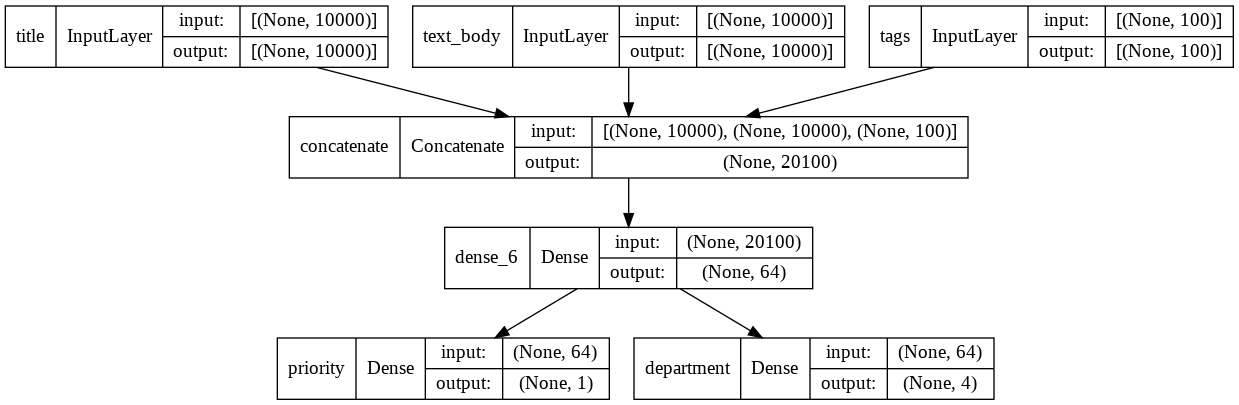

In [10]:
#Topology of the model
#Note that "None" is shape represents the sample size, it can be anyting you want
keras.utils.plot_model(model, "ticket_classifier.png", show_shapes=True)

* You can inspect the layers like shown below -

In [11]:
#Looking at model layers
model.layers

In [12]:
#looking at details of your model graph
model.layers[0], model.layers[0].input, model.layers[0].output 

(<keras.engine.input_layer.InputLayer at 0x7f13906f04d0>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>)

* Feature Extraction :  You can extract features from a trained model and build a new model by *extracting features* from any given layer as shown below -

In [13]:
#getting output of 5th layer or the first dense layer
features = model.layers[4].output
#building new model that can classify into 3 classes
#this way you don't have to code model from scratch
difficulty = layers.Dense(3, "softmax")(features)

new_model = keras.Model(inputs=[title, text_body, tags],
                        outputs=[priority, department, difficulty])

### Model Subclassing 

This approach of building model is the most advanced one. Need to do the following steps:
* In the \_\_init__() menthod, define all the layers you would want in your network
* In the call() method, define the forward pass of the model, using these layers.
* Instantiate your model class and call it on data. This will create the weights. 
* Rewriting the above example using subclassing -

In [17]:
#Defining a Model subclass
class CustomerTicketModel(keras.Model):

  def  __init__(self, num_departments):
    #calling super constructor
    super().__init__()
    #Defining sublayers
    self.concat_layer = layers.Concatenate()
    self.mixing_layer = layers.Dense(64, "relu")
    self.priority_scorer = layers.Dense(1, "sigmoid")
    self.department_classifier = layers.Dense(num_departments, "softmax")

  #Dfining forward pass for the model
  def call(self, inputs):
    title = inputs['title']
    text_body = inputs['text_body']
    tags = inputs['tags']
    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)
    priority = self.priority_scorer(features)
    department = self.department_classifier(features)
    return priority, department

#Lets instantiate the model
model = CustomerTicketModel(num_departments=4)

#Model will create the weights only when called on some data 
priority, department =  model({'title':title_data, 'text_body':text_body_data, 'tags':tags_data})

* Compiling and training is the same as Functionla and Sequential API style -

In [18]:
#make sure the loss and metrics values are in sam order as what call() is returning 
model.compile(optimizer="rmsprop", loss=["mean_squared_error","categorical_crossentropy"], metrics=[["mean_absolute_error"], "accuracy"])

#again order of target data should be same as what call() method is returning
#also order of inputs should match exactly what call() is expecting
model.fit({'title':title_data, 'text_body':text_body_data, 'tags':tags_data},
          [priority_data, department_data],
          epochs=1)

model.evaluate({'title':title_data, 'text_body':text_body_data, 'tags':tags_data}, [priority_data, department_data])

priority_preds, department_preds = model.predict({'title':title_data, 'text_body':text_body_data, 'tags':tags_data})

40/40 [==============================] - 0s 5ms/step - loss: 17.6170 - output_1_loss: 0.3282 - output_2_loss: 17.2888 - output_1_mean_absolute_error: 0.4927 - output_2_accuracy: 0.2336


Difference between Functional API and Model Subclassing :
1. Functional model acts like a data structure - A graph of layers, which you can view, inspect and modify. While a Sublclass model is like piece of code - a Python class with a call() menthod which contains forward pass or raw code.

2. In using a Subclass model you can write any type of layers in the call() method with whaterer type of cunctionallity. Functional model has limited functionality in that way. 

3. Unlike a Functonal model, for Subclass model you can't plot the model using plot_model(), also since the way layers are connecte to each other, is hidden inside the call() method, summary() function wiilll not be able to display layer connectivity clearly. 

4. Lastly unlike Functional API, you cant do feature extraction using nodes of the graph as you can't access them in the call() method.

In [19]:
model.summary()

Model: "customer_ticket_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concatenate_3 (Concatenate)  multiple                 0         
                                                                 
 dense_14 (Dense)            multiple                  1286464   
                                                                 
 dense_15 (Dense)            multiple                  65        
                                                                 
 dense_16 (Dense)            multiple                  260       
                                                                 
Total params: 1,286,789
Trainable params: 1,286,789
Non-trainable params: 0
_________________________________________________________________


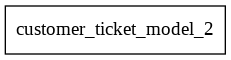

In [20]:
keras.utils.plot_model(model, "ticket_classifier.png", show_shapes=True)

### Which model types to use 

* You can use Sequential, Functional and Subclass model features collectively as well. All models can smoothly interpolate between one another as well.

* Functional API provides you with good trade off between between ease of use and flexibility. Helps greatly with its feature extraction capabilities. 

* If a model can be expessed as a graph of layer, Functional API can pretty much implement everything. We can use suclass layers in between to get the best of both worlds.

## Different workflows for training models in Keras

* It can be easiest like model.fit() to a more flexible entirely new training algorithm from scratch.

* Lets look at an example of compiiile(), fit(), evaluate() and predict() -
  * model.fit - To train the moddel using trai data, optionally provideing validation data for performance monitorinng
  * model.evaluate - To calculate model loss and metrics on test data
  * model.predict - To compute classification probabilities for new test data



In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

#Defininig model
def get_mnist_model():
  inputs = keras.Input(shape=(28*28,))
  features = layers.Dense(512, "relu")(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, "softmax")(features)
  model = keras.Model(inputs, outputs)
  return model

#Preparing data
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype('float32')/255
test_images = test_images.reshape((10000, 28*28)).astype('float32')/255
train_images, val_images = images[10000:], images[:10000] 
train_labels, val_labels = labels[10000:], labels[:10000] 

model = get_mnist_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/3
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2918 - accuracy: 0.9140 - val_loss: 0.1476 - val_accuracy: 0.9597
Epoch 2/3
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1634 - accuracy: 0.9538 - val_loss: 0.1233 - val_accuracy: 0.9662
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1085 - accuracy: 0.9718


**Lets modify this above model a bit -**
* By creating our own metrics
* Passing *callbacks* to the model.fit() method to schedlue actions that can be taken up during training at specific points.

**Creating our own metrics**

* A keras metric is a subclass of keras.metrics.Metric class 
* 

In [11]:
import tensorflow as tf
from tensorflow import keras

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [12]:
#Trying out own own created metric above
model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy",RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2933 - accuracy: 0.9136 - rmse: 7.1833 - val_loss: 0.1425 - val_accuracy: 0.9584 - val_rmse: 7.3682
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1672 - accuracy: 0.9533 - rmse: 7.3547 - val_loss: 0.1298 - val_accuracy: 0.9652 - val_rmse: 7.4027
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1025 - accuracy: 0.9736 - rmse: 7.4335


### Callbacks

* Keras *callbacks* API helps you ttransform your model.fit() to dynamically inspect the output during the training process and also to take action on it.

* Callback is an object or a class instance that is passed to the model in call to fit() and it is then called by the model at various points during training.

* Callback has all the data about the state of the model and its performance. It can take actions like - interuppt training, save model, load differnet weights and alter model state.

* Some usecase -
  * Model Checkpoints : saving state of the model at different stages of traiining.
  * Early stopping : Interrupting trainng process on conditions like when validation loss is no longer improving.
  * Dynamically changing the values of certain hyperparameter : like lowering the learning rate during the trainnig.
  * Logging training and validation metrics durring training 
  * Visualizing the representations learned by the model as it gets updated. 

Some of the most used builtin callbacks in keras are  -
```
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
```

**Early Stoping**
* A good way to handle overfitting is to use callback option called Early Stopping. It means stopping the training of your model if the model is no longer imporoving the validation loss.
* When the target metrics stops improving for a fixed number of Epochs, Early Stopping callback halts the training process.

**Model cHeckpoiniting**
* Lets you continuously save the model during trainig or saving the *best model* so far.

Lets understand the both using an example -
* Here, EarlyStopping is monitoring the validation accuracy, and it interrupts training when val accuracy stops improving for two continuous epochs.
* ModelCheckpoint helps in saving the current model. Here, it will monitor validation loss and overrite the saved weight file only when val loss has decreased (improved). Thus you can save the best model see during training process.

Note that, you can save model weights and load them back using these methods too - 
```
model.save('checkpoint_path')
model.load_model('checkpointpath.keras')
```

In [ ]:
from tensorflow.python.util.nest import flatten_with_tuple_paths

#fit takes a list of callbacks
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2,),
                  keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras", monitor='val_loss',save_best_only=True,)]

model=get_mnist_model()
#monitoring accuracy in callback so it sould be part of compile metrics
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#running for higher epochs than usual here to check early stopping - training will stop around 13 epochs
model.fit(train_images, train_labels, epochs=20,callbacks=callbacks_list, validation_data=(val_images, val_labels))


**Writing own callbacks**
* By subclassing the keras.callbacks.Callback class.
* Helps you in taking a sppecific action during training that is not covered by the default options.

In [21]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### TensorBoard
Tensorboard is a callback and runs as a browser based application and it is used to monitor your model's traininig in visual manner.
* It helps you in getting more information about your model performance.
* You need a tool to process all the information your model generates.
* Keras takes you from idea to implementation, GPU clusters take you from implementation to results, and TensorBoard  takes you from results to deeper understanding using visualizations.

Some of the visualizations that you can do using Tensorboard are -
* Model metrics during training,
* Model architecture
* Activations and gradients
* Exploring embeddings


In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#need to specify where callback will write the logs
tensorboard = keras.callbacks.TensorBoard(
    log_dir="/dir_full_path",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /dir_full_path

*Displaying the output as an image as github is not render this in browser display of Tensorboard*

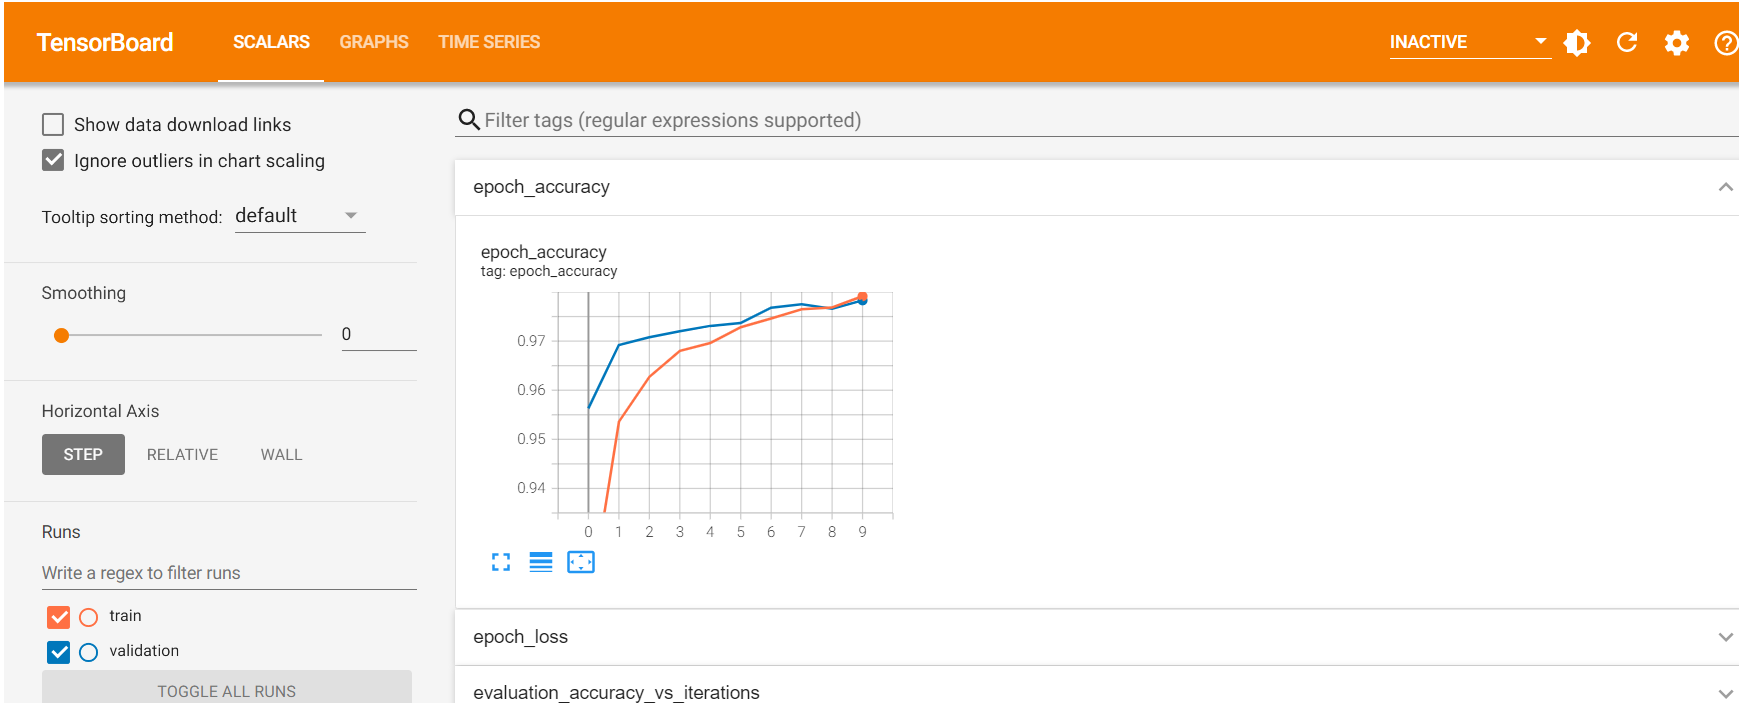

## Writing own Training and Evaluation Loops
* The built-in fit() function works for Supervised problem setting, i.e. when you have labels or targets for your input dataset. 
* In ML space, there can be diffferent problem scenarios as well, like Self-supervised learning where targets are obtained from the input itself, or reinforcement learning where learninig is driven by *rewards* and many more.
* In these cases you have to write your own training procedure and can't use the fit() method as such.
* A traiing loop can look like follwoing steps per batch --
  1. Run forward pass (another way to say this is, compute your model's output) and compute loss value. This can be done inside the tensorflow Gradient Tape. I talked about it in my second notebook in details. You can read it over here - [Introduction to Keras and TensorFlow](https://github.com/yvrjsharma/Keras-edition-deux/blob/main/Keras_2.ipynb).
  2. Retrieve the gradient of loss fucntion with respect to model weights.
  3. Update model weights.
